In [1]:
import os
image_path = "../dataset/pizza_steak_sushi/"

train_dir = os.path.join(image_path, "train")
test_dir = os.path.join(image_path, "test")

In [2]:
from torchvision import transforms
from data_setup import createDataloader

train_transform = transforms.Compose(
    [   
        transforms.Resize((224, 224)) ,
        transforms.ToTensor()

    ]
)

train_DL, test_DL, _classes = createDataloader(train_dir, test_dir, 32, train_transform, train_transform )

In [3]:
len(train_DL)

8

In [4]:
_classes

['pizza', 'steak', 'sushi']

12


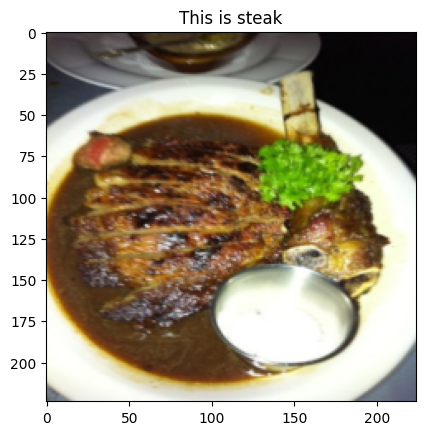

In [5]:
# data visuals
import  matplotlib.pyplot as plt
from PIL import Image
import random

img, lable = next(iter(test_DL))

rand_id = random.randint(0,31)
print(rand_id)

show_img = img[rand_id]
plt.title("This is {}".format(_classes[lable[rand_id]]))
plt.imshow(show_img.permute(1,2,0))

# Replicating ViT

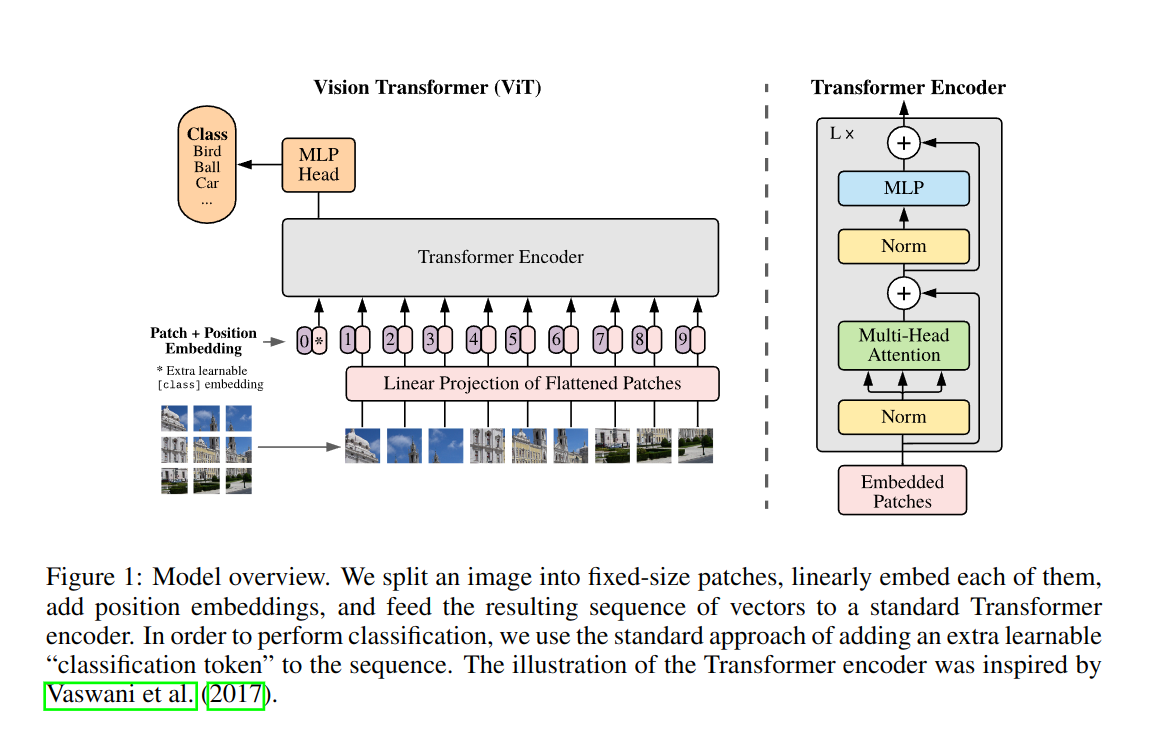

### Embedding - Leaning representations, start from a random initialization and improve them through training.
    - 1D vector will be input to the model


##### * Equation 1
```python
x_input = [class_token, image_patch1, image_patch2,.. image_patchN] + [class_token_pos, image_patch1_pos, image_patch2_pos,.. image_patchN_pos]
```

##### * Equation 2
```python
x_MSA_output = MultiHSA(LayerNorm(x_input)) + x_input
```

##### * Equation 3
```python
x_MLP_output = MLP(LayerNorm(x_MSA_output)) + x_MSA_output
```

<b>MLP - Multi Layer Perceptron (a nn with multiple layers)</b>

##### Equation 4 - Output
```python
x_output = LinearLayer(LayerNorm(x_MLP_output))
```

## Patch position and class Embeding

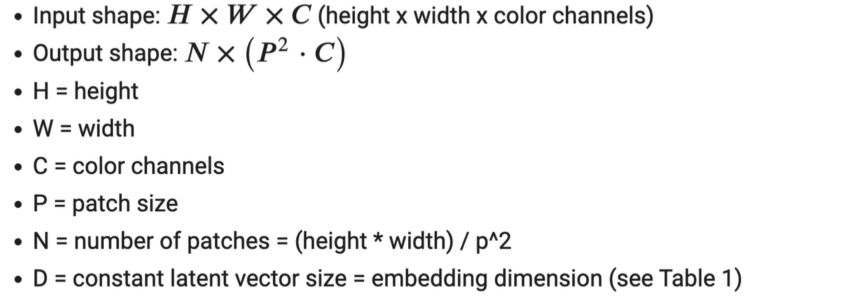

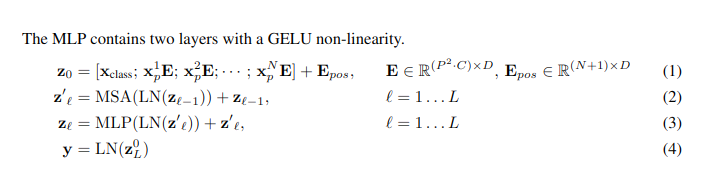

In [6]:
H = 224
W = 224
C = 3
P = 16
N = int((H * W) / P**2)
N

196

In [7]:
#adding

# EQ 1. Patch Embbeding with Positional Encoding
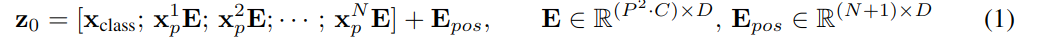

In [8]:
# compliling eq.1 in a single block of code
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

single_img = next(iter(test_DL))[0][0].unsqueeze(0) # single img of batch 1

# patch embb code
class PatchEmbeddingWithPosEmbb(nn.Module):
    def __init__(self, color_channel, out_num_patch, patch_size):
        super().__init__()
        self.conv_layer = nn.Conv2d(in_channels=color_channel, 
                               out_channels=out_num_patch,
                               kernel_size=patch_size,
                               stride=patch_size, 
                               padding=0)
        self.flat = nn.Flatten(start_dim=2, end_dim=3)
    
    # Class Token (B, 1, embedding_token) concat to Patched image (B, no_of_patches, embedding_token) = (B, 1+no_of_patches, embedding_token)
    def class_token(self, patch_embb):
        class_token_layer = nn.Parameter(torch.randn(patch_embb.shape[0], 1, patch_embb.shape[2]), requires_grad=True).to(device=device) # (B, 1, 768)
        return torch.cat((class_token_layer, patch_embb),dim=1)
    
    # Adding Patched Embb with Class Token - (B, 1+no_of_patches, Emmbed_dim)
    def position_embbeding(self, patch_embb):
        pos_embb_layer = nn.Parameter(torch.ones(patch_embb.shape), requires_grad=True).to(device)
        return torch.add(patch_embb, pos_embb_layer) # (B, 196, 768) + (B, 196, 768) 

    def forward(self, x):
        x = self.conv_layer(x) # Patched Imgae - (batch, C, H, W) --> (Batch, no_of_patches, embedding_dim patches)
        x = self.flat(x).permute(0,2,1)
        x = self.class_token(x)
        return self.position_embbeding(x)
    
# pe = PatchEmbeddingWithPosEmbb(3, 768, 16).to(device)
# gpu_img = img.to(device)
# input_patch_embedding = pe(gpu_img)
# print(input_patch_embedding.shape)

# EQ 2. Multi Head Self Attention with Layer Normalization with previous output


In [9]:
# layer_norm = nn.LayerNorm(normalized_shape=input_patch_embedding.shape).to(device)
# layer_norm_embb = layer_norm(input_patch_embedding)
# multi_head = nn.MultiheadAttention(embed_dim=768, num_heads=6).to(device)
# atten, _ = multi_head(query=layer_norm_embb, key=layer_norm_embb, value=layer_norm_embb, need_weights=True)
# atten.shape

In [10]:
class MultiheadSelfAttention(nn.Module):
    def __init__(self, embb_dim: int, num_heads: int, attn_dropout: 0):
        super().__init__()
        
        # layernorm
        self.layer_norm = nn.LayerNorm(normalized_shape=embb_dim)
        
        # multi head, we have (B, NumPatch, EmbedDim) or (B, Seq, Feat)
        self.multiHead = nn.MultiheadAttention(embed_dim=embb_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        atten_out, _ = self.multiHead(query=x, key=x, value=x,need_weights=False)
        return atten_out


In [11]:
# MSA = MultiheadSelfAttention(embb_dim=768, num_heads=12, attn_dropout=0).to(device)
# MSA_pateched_img = MSA(input_patch_embedding)

In [ ]:
# print("Shape of Input patch embb: {}".format(input_patch_embedding.shape))
# print("Shape of MSA patch embb: {}".format(MSA_pateched_img.shape))

In [13]:
# input_patch_embedding[0,0,:10]

In [ ]:
# MSA_pateched_img[0,0,:10]

# EQ 3. MLP with Layer Normalization with previous output
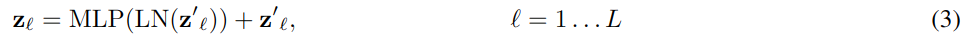

In [15]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, preceptron: int,embb_dim: int, dropout: float):
        super().__init__()
        
        # layernorm
        self.layer_norm = nn.LayerNorm(normalized_shape=embb_dim)
        
        self.mlp_layer = nn.Sequential(
            nn.Linear(in_features=embb_dim, out_features=preceptron),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=preceptron, out_features=embb_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        return self.mlp_layer(x)

In [ ]:
# MLP_block = MultiLayerPerceptron(embb_dim=768, preceptron=3072, dropout=0).to(device)
# MLP_block(MSA_pateched_img).shape

In [17]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, color_c: int, out_patch_num: int, patch_size: int, heads: int, attn_dropout: float, perceptron: int, mlp_dropout: float ):
        super().__init__()
        self.MSA = MultiheadSelfAttention(embb_dim=out_patch_num, num_heads= heads, attn_dropout=attn_dropout)
        self.MLP = MultiLayerPerceptron(perceptron, embb_dim=out_patch_num, dropout=mlp_dropout)

    def forward(self, x):
        msa_out = self.MSA(x) + x
        mlp_out = self.MLP(msa_out) + msa_out
        return mlp_out
    
# transformer = TransformerEncoderBlock(3, 768, 16, 12, 0, 3072, 0).to(device)
# transformer(input_patch_embedding).shape

In [ ]:
# img.shape

In [19]:
from torchinfo import summary

In [ ]:

# summary(transformer, input_size=(32,197, 768), col_names=["input_size", "output_size", "num_params", "trainable"])
# summary(transformer, input_size=(32, 197, 768), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=["var_names"])

In [21]:
# Crete Transformer Encoder with torch transformer module

In [22]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, 
                                                             nhead=12, 
                                                             dim_feedforward=3072,
                                                             activation=nn.GELU(),
                                                             device=device,
                                                             batch_first=True,
                                                             norm_first=True,
                                                             dropout=0.1)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (activation): GELU(approximate='none')
)

In [23]:
summary(torch_transformer_encoder_layer, 
        input_size=(32, 197, 768), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [32, 197, 768]       [32, 197, 768]       --                   True
├─LayerNorm (norm1)                                [32, 197, 768]       [32, 197, 768]       1,536                True
├─MultiheadAttention (self_attn)                   [32, 197, 768]       [32, 197, 768]       2,362,368            True
├─Dropout (dropout1)                               [32, 197, 768]       [32, 197, 768]       --                   --
├─LayerNorm (norm2)                                [32, 197, 768]       [32, 197, 768]       1,536                True
├─Linear (linear1)                                 [32, 197, 768]       [32, 197, 3072]      2,362,368            True
├─GELU (activation)                                [32, 197, 3072]      [32, 197, 3072]      --                   --
├─Dropout (dropout)                            

In [30]:
class VitArch(nn.Module):
    def __init__(self, 
                 img_size: int = 224,
                 in_channel: int=3,
                 batch_size: int = 32,
                 patch_size: int = 16,
                 num_transformer_layer:int = 12,
                 embedding_dim: int = 768,
                 mlp_size: int = 3072,
                 num_heads: int=12,
                 atten_dropout: float=0,
                 mlp_dropout: float=0.1,
                 embedding_dropout=0.1,
                 num_classes=1000
                 ):
        super().__init__()
        self.patch_em = PatchEmbeddingWithPosEmbb(in_channel, embedding_dim, patch_size)
        # nn.TransformerEncoderLayer(d_model=embedding_dim,
        #                                                       nhead=num_heads,
        #                                                       dim_feedforward=3072,
        #                                                       dropout=atten_dropout)
        self.embeding_dropout = nn.Dropout(p=embedding_dropout)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(color_c=in_channel, out_patch_num=embedding_dim,
                                                           patch_size=patch_size, heads=num_heads, attn_dropout=atten_dropout, 
                                                           perceptron=mlp_size, mlp_dropout=mlp_dropout) for _ in range(num_transformer_layer)])
        
        self.classifer = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.patch_em(x)
        x = self.embeding_dropout(x)
        x = self.transformer_encoder(x)
        print(x.shape, x[:, 0].shape)
        return self.classifer(x[:, 0])

In [32]:
vit = VitArch(num_classes=3)

In [36]:
summary(vit, input_size=(img.shape), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

torch.Size([32, 197, 768]) torch.Size([32, 768])


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
VitArch (VitArch)                                       [32, 3, 224, 224]    [32, 3]              --                   True
├─PatchEmbeddingWithPosEmbb (patch_em)                  [32, 3, 224, 224]    [32, 197, 768]       --                   True
│    └─Conv2d (conv_layer)                              [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flat)                                   [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embeding_dropout)                            [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                      [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                      [32, 197, 768]       [32, 197, 768]       --                   True
│    │ 

In [ ]:
from utils import trainit


loss_fn = nn.CrossEntropyLoss().to(device)
optim = torch.optim.Adam(vit.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.3)

trainit(vit, train_DL, test_DL, loss_fn, optim, 10, True, device)